In [1]:
!pip install nltk

In [2]:
import nltk
nltk.download('reuters')  # Download the Reuters corpus
nltk.download('punkt')

from nltk.corpus import reuters
import re
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

import tkinter as tk
from tkinter import Label, Entry, Button, Text, Scrollbar

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
# Access the text data
corpus = reuters.raw()

In [4]:
class NGramLanguageModel:
    """
    Class for creating an n-gram language model.
    """
    def __init__(self, corpus, n=2):
        """
        Initialize the n-gram language model.

        Parameters:
        - corpus (str): The text corpus to be used for training the model.
        - n (int): The size of the n-grams.
        """
        self.corpus = corpus
        self.n = n
        self.clean_corpus = self.preprocess_text()
        self.tokenized_text = word_tokenize(self.clean_corpus)
        self.vocab_size = len(set(self.tokenized_text))
        self.ngrams = self.create_ngrams(self.tokenized_text)
        self.ngram_freq = self.cal_ngram_freq(self.ngrams)

    def preprocess_text(self):
        """
        Clean and preprocess the given text.

        Returns:
        str: The preprocessed text.
        """
        # remove special characters
        text = re.sub(r'[^a-zA-Z\s]', '', self.corpus)
        # convert to lowercase
        text = text.lower()
        return text

    def create_ngrams(self, tokens):
        """
        Create n-grams from a list of tokens.

        Parameters:
        - tokens (list): List of tokens.

        Returns:
        list: List of n-grams.
        """
        ngrams = []
        # iterate over the range of indices to create n-grams
        for i in range(len(tokens) - self.n + 1):
            # extract a tuple of n tokens from the current position
            ngram = tuple(tokens[i:i + self.n])
            # append the n-gram to the list
            ngrams.append(ngram)
        return ngrams

    def cal_ngram_freq(self, ngrams):
        """
        Calculate the frequency of each n-gram in the dataset.

        Parameters:
        - ngrams (list): List of n-grams.

        Returns:
        Counter: A Counter object containing the frequencies of each n-gram.
        """
        return Counter(ngrams)

    def calculate_probability(self, word, last_ngram):
        """
        Calculate the probability of a word following a given (n-1)-gram using Laplace smoothing.

        Parameters:
        - word (str): The word for which the probability is calculated.
        - last_ngram (tuple): The (n-1)-gram preceding the word.

        Returns:
        float: The probability of the word following the given (n-1)-gram.
        """
        # with laplace smoothing
        numeratorProb = self.ngram_freq[last_ngram + (word,)] + 1
        denominatorProb = self.ngram_freq[last_ngram] + self.vocab_size
        return numeratorProb / denominatorProb

    def predict_next_word(self, last_ngram):
        """
        Predict the next word given a sequence of words based on n-gram probabilities.

        Parameters:
        - last_ngram (tuple): The (n-1)-gram preceding the next word.
        - ngram_freq (Counter): Frequencies of n-grams in the dataset.

        Returns:
        str: The predicted next word.
        """
        next_word_counts = defaultdict(int)
        # First, check if the first (n-1) elements of the current n-gram match the provided (n-1)-gram
        # then, create a set from the list of next words
        for ngram in self.ngram_freq:
            if ngram[:-1] == last_ngram:
                next_word_counts[ngram[-1]] += self.ngram_freq[ngram]
        next_word_counts = set([ngram[-1] for ngram in self.ngram_freq if ngram[:-1] == last_ngram])
        # If there are no possible next words, return a default value (e.g., "<UNKNOWN>")
        if not next_word_counts:
            return "<UNKNOWN>"
        probabilities = {word: self.calculate_probability(word, last_ngram) for word in next_word_counts}
        # return word with highest probability
        most_common_word = max(probabilities, key=probabilities.get)
        return most_common_word


    def generate_sentence(self, prefix, length):
        """
        Generate a sentence of a specified length given a prefix of (n-1) words.

        Parameters:
        - prefix (list): The prefix of the sentence.
        - length (int): The length of the generated sentence.

        Working:
        Suppose prefix = ['the', 'quick'], and the length of the generated sentence is 3.
        The function will start with the prefix and iteratively predict the next word to extend the sentence.
        It will generate the following sequence of (n-1)-grams:
        Iteration 1: prev_ngram = tuple(['the', 'quick'])
        Iteration 2: prev_ngram = tuple(['quick', 'predicted_word1'])
        Iteration 3: prev_ngram = tuple(['predicted_word1', 'predicted_word2'])

        Returns:
        str: The generated sentence.
        """
        generated_sentence = prefix.copy()
        # generate the next word until the sentence reaches the desired length
        while len(generated_sentence) < length + len(prefix):
            # get the last (n-1) words of the generated sentence
            prev_ngram = tuple(generated_sentence[-self.n + 1:])
            # predict the next word
            predicted_word = self.predict_next_word(prev_ngram)
            # append the predicted word to the generated sentence
            generated_sentence.append(predicted_word)
        return ' '.join(generated_sentence[len(prefix):])


    def get_ngrams(self):
        """
        Get the n-grams in the dataset.

        Returns:
        list: List of n-grams.
        """
        return self.ngrams

    def get_ngram_freq(self):
        """
        Get the frequencies of n-grams in the dataset.

        Returns:
        Counter: A Counter object containing the frequencies of each n-gram.
        """
        return self.ngram_freq

In [5]:
bigram_model = NGramLanguageModel(corpus, n=2)
bigrams = bigram_model.get_ngrams()
bigrams[:10]

[('asian', 'exporters'),
 ('exporters', 'fear'),
 ('fear', 'damage'),
 ('damage', 'from'),
 ('from', 'usjapan'),
 ('usjapan', 'rift'),
 ('rift', 'mounting'),
 ('mounting', 'trade'),
 ('trade', 'friction'),
 ('friction', 'between')]

In [6]:
trigram_model = NGramLanguageModel(corpus, n=3)
trigrams = trigram_model.get_ngrams()
trigrams[:10]

[('asian', 'exporters', 'fear'),
 ('exporters', 'fear', 'damage'),
 ('fear', 'damage', 'from'),
 ('damage', 'from', 'usjapan'),
 ('from', 'usjapan', 'rift'),
 ('usjapan', 'rift', 'mounting'),
 ('rift', 'mounting', 'trade'),
 ('mounting', 'trade', 'friction'),
 ('trade', 'friction', 'between'),
 ('friction', 'between', 'the')]

In [7]:
# Example for bigram frequencies
bigram_frequencies = bigram_model.get_ngram_freq()
# Print the 10 most common bigrams
bigram_frequencies.most_common(10)

[(('in', 'the'), 7091),
 (('of', 'the'), 6908),
 (('said', 'the'), 5353),
 (('mln', 'dlrs'), 4400),
 (('said', 'it'), 4343),
 (('vs', 'mln'), 3945),
 (('mln', 'vs'), 3921),
 (('cts', 'vs'), 3311),
 (('for', 'the'), 2806),
 (('the', 'company'), 2607)]

<ipython-input-8-ee86f37b3618>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=bigram_labels, y=bigram_counts, palette="viridis")
<ipython-input-8-ee86f37b3618>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)


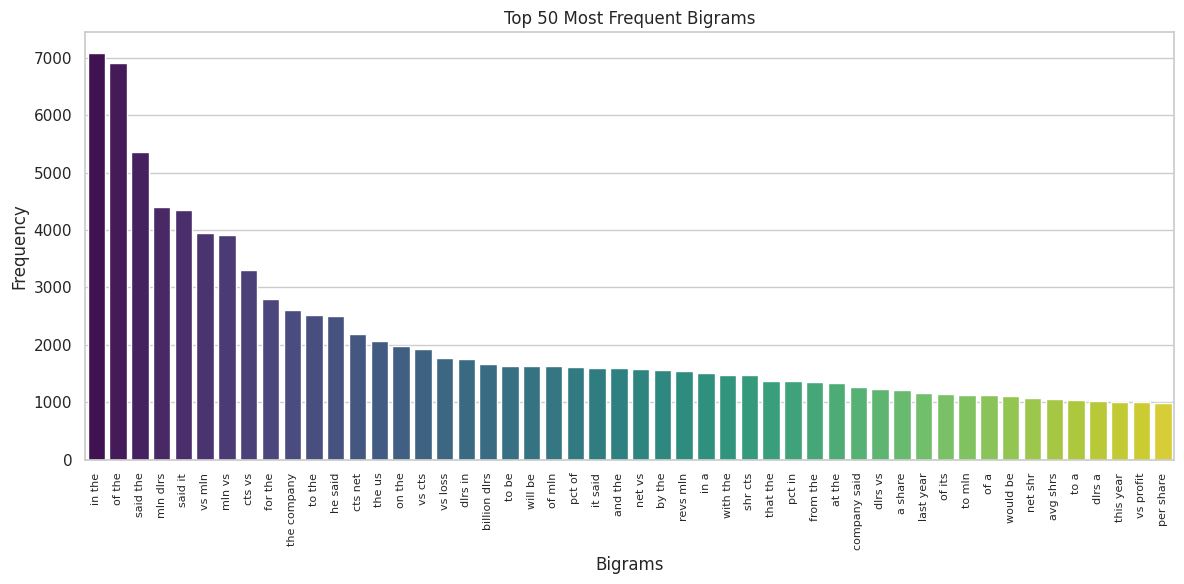

In [8]:
# Get the top 50 most frequent bigrams
top_50_bigrams = dict(bigram_frequencies.most_common(50))

# Extract bigram labels and frequencies
bigram_labels = [' '.join(bigram) for bigram in top_50_bigrams.keys()]
bigram_counts = list(top_50_bigrams.values())

# Set Seaborn style
sns.set(style="whitegrid")

# Plotting with Seaborn
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=bigram_labels, y=bigram_counts, palette="viridis")
ax.set(xlabel='Bigrams', ylabel='Frequency')
ax.set_title('Top 50 Most Frequent Bigrams')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
plt.tight_layout()
plt.show()